In [78]:
import gym
import tensorflow as tf
from collections import deque
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from gym import wrappers

In [79]:
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env,'./monitor')

[2017-07-15 09:02:59,428] Making new env: FrozenLake-v0


In [80]:
print(env.observation_space.n)
print(env.action_space.n)

16
4


In [18]:
state = env.reset()
for i in range(10):
    #env.render()
    action = env.action_space.sample()
    next_state, reward, done, prob = env.step(action)
    print('state:{} action:{} next_state:{} reward:{} done:{}'.format(state, action, next_state, reward, done))
    state = next_state
    if done:
        break

state:0 action:1 next_state:1 reward:0.0 done:False
state:1 action:1 next_state:0 reward:0.0 done:False
state:0 action:1 next_state:4 reward:0.0 done:False
state:4 action:0 next_state:4 reward:0.0 done:False
state:4 action:1 next_state:4 reward:0.0 done:False
state:4 action:3 next_state:5 reward:0.0 done:True


In [81]:
learning_rate = 0.01
memory_size = 2000

episodes = 2000
steps = 100
# changed from 0.95
gamma = 0.95

epsilon = 1
epsilon_stop = 0.01
epsilon_decay = 0.99
batch_size = 32

In [82]:
bot = Sequential()
bot.add(Dense(10, input_dim=16, activation='relu'))
bot.add(Dense(4, activation='linear'))
bot.compile(loss='mse', optimizer = Adam(learning_rate))
memory = deque(maxlen=memory_size)

In [83]:
state_lkup = np.eye(env.observation_space.n)
action_lkup = np.eye(env.action_space.n)

In [ ]:
reward_list=[]
state = env.reset()
for episode in range(episodes):
    total_reward = 0
    state = env.reset()
    for step in range(steps):
        if epsilon > np.random.rand():
            action = env.action_space.sample()
        else:
            action = np.argmax(bot.predict(np.reshape(state_lkup[state], (-1, env.observation_space.n))))
        next_state, reward, done, prob = env.step(action)
        if done and reward==0:
            reward = -1
        if not done and reward==0:
            reward = -0.02
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward = total_reward + reward
        if done:
            print('episode:{} steps:{} total reward:{} epsilon:{}'.format(episode + 1, step + 1, total_reward, epsilon))
            reward_list.append(total_reward)
            break
        
        minibatch = [memory[ii] for ii in np.random.choice(range(len(memory)), batch_size)]
        states = [each[0] for each in minibatch]
        actions = [each[1] for each in minibatch]
        rewards = [each[2] for each in minibatch]
        next_states = [each[3] for each in minibatch]
        dones = [each[4] for each in minibatch]
        
        next_states = np.reshape([state_lkup[state] for state in next_states], [-1,env.observation_space.n])
        states = np.reshape([state_lkup[state] for state in states], [-1,env.observation_space.n])
        actions = np.reshape(actions, (batch_size, 1))
        targetQs = bot.predict(next_states)
        episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
        targetQs[episode_ends] = (0, 0, 0, 0)
        
        targets = rewards + gamma * np.max(targetQs, axis=1)
        targets_f = bot.predict(states)
        
        for pos in range(len(actions)):
            targets_f[pos,actions[pos]] = targets[pos]
        
        bot.fit(states, targets_f, epochs=1, verbose=0)
    if epsilon > epsilon_stop:
        epsilon = epsilon * epsilon_decay

[2017-07-15 09:03:11,304] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000000.json
[2017-07-15 09:03:11,319] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000001.json


episode:1 steps:6 total reward:-1.1 epsilon:1
episode:2 steps:8 total reward:-1.1400000000000001 epsilon:0.99
episode:3 steps:4 total reward:-1.06 epsilon:0.9801
episode:4 steps:15 total reward:0.72 epsilon:0.9702989999999999


[2017-07-15 09:03:12,703] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000008.json


episode:5 steps:9 total reward:-1.16 epsilon:0.96059601
episode:6 steps:13 total reward:-1.24 epsilon:0.9509900498999999
episode:7 steps:4 total reward:-1.06 epsilon:0.9414801494009999
episode:8 steps:2 total reward:-1.02 epsilon:0.9320653479069899
episode:9 steps:8 total reward:-1.1400000000000001 epsilon:0.92274469442792
episode:10 steps:9 total reward:-1.16 epsilon:0.9135172474836407
episode:11 steps:8 total reward:-1.1400000000000001 epsilon:0.9043820750088043
episode:12 steps:13 total reward:-1.24 epsilon:0.8953382542587163
episode:13 steps:3 total reward:-1.04 epsilon:0.8863848717161291
episode:14 steps:8 total reward:-1.1400000000000001 epsilon:0.8775210229989678
episode:15 steps:21 total reward:-1.4000000000000001 epsilon:0.8687458127689781
episode:16 steps:13 total reward:-1.24 epsilon:0.8600583546412883
episode:17 steps:2 total reward:-1.02 epsilon:0.8514577710948754
episode:18 steps:13 total reward:-1.24 epsilon:0.8429431933839266
episode:19 steps:5 total reward:-1.08 epsilo

[2017-07-15 09:03:13,615] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000027.json


episode:26 steps:12 total reward:-1.22 epsilon:0.7778213593991465
episode:27 steps:3 total reward:-1.04 epsilon:0.7700431458051551
episode:28 steps:7 total reward:-1.12 epsilon:0.7623427143471035
episode:29 steps:11 total reward:-1.2 epsilon:0.7547192872036325
episode:30 steps:8 total reward:-1.1400000000000001 epsilon:0.7471720943315961
episode:31 steps:8 total reward:-1.1400000000000001 epsilon:0.7397003733882802
episode:32 steps:4 total reward:-1.06 epsilon:0.7323033696543974
episode:33 steps:11 total reward:-1.2 epsilon:0.7249803359578534
episode:34 steps:7 total reward:-1.12 epsilon:0.7177305325982748
episode:35 steps:11 total reward:-1.2 epsilon:0.7105532272722921
episode:36 steps:14 total reward:-1.26 epsilon:0.7034476949995692
episode:37 steps:17 total reward:-1.32 epsilon:0.6964132180495735
episode:38 steps:9 total reward:-1.16 epsilon:0.6894490858690777
episode:39 steps:30 total reward:-1.58 epsilon:0.682554595010387
episode:40 steps:8 total reward:-1.1400000000000001 epsilon

[2017-07-15 09:03:16,008] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000064.json


episode:63 steps:14 total reward:-1.26 epsilon:0.536268225207185
episode:64 steps:17 total reward:-1.32 epsilon:0.5309055429551132
episode:65 steps:12 total reward:-1.22 epsilon:0.525596487525562
episode:66 steps:18 total reward:-1.34 epsilon:0.5203405226503064
episode:67 steps:4 total reward:-1.06 epsilon:0.5151371174238033
episode:68 steps:12 total reward:-1.22 epsilon:0.5099857462495653
episode:69 steps:15 total reward:-1.28 epsilon:0.5048858887870696
episode:70 steps:6 total reward:-1.1 epsilon:0.4998370298991989
episode:71 steps:11 total reward:-1.2 epsilon:0.49483865960020695
episode:72 steps:2 total reward:-1.02 epsilon:0.4898902730042049
episode:73 steps:2 total reward:-1.02 epsilon:0.48499137027416284
episode:74 steps:5 total reward:-1.08 epsilon:0.4801414565714212
episode:75 steps:13 total reward:-1.24 epsilon:0.475340042005707
episode:76 steps:13 total reward:-1.24 epsilon:0.47058664158564995
episode:77 steps:15 total reward:-1.28 epsilon:0.4658807751697934
episode:78 steps:

[2017-07-15 09:03:20,495] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000125.json


episode:122 steps:28 total reward:-1.54 epsilon:0.2963865873992079
episode:123 steps:13 total reward:-1.24 epsilon:0.29342272152521587
episode:124 steps:13 total reward:-1.24 epsilon:0.2904884943099637
episode:125 steps:12 total reward:-1.22 epsilon:0.28758360936686406
episode:126 steps:9 total reward:-1.16 epsilon:0.2847077732731954
episode:127 steps:8 total reward:-1.1400000000000001 epsilon:0.28186069554046345
episode:128 steps:17 total reward:-1.32 epsilon:0.2790420885850588
episode:129 steps:8 total reward:-1.1400000000000001 epsilon:0.2762516676992082
episode:130 steps:19 total reward:-1.36 epsilon:0.27348915102221616
episode:131 steps:46 total reward:-1.9000000000000004 epsilon:0.270754259511994
episode:132 steps:20 total reward:-1.3800000000000001 epsilon:0.26804671691687404
episode:133 steps:34 total reward:-1.6600000000000001 epsilon:0.2653662497477053
episode:134 steps:16 total reward:-1.3 epsilon:0.2627125872502282
episode:135 steps:24 total reward:0.5399999999999998 epsilo

[2017-07-15 09:03:35,948] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000216.json


episode:215 steps:100 total reward:-2.9800000000000013 epsilon:0.11639428152900344
episode:216 steps:26 total reward:-1.5 epsilon:0.11523033871371341
episode:217 steps:10 total reward:-1.18 epsilon:0.11407803532657627
episode:218 steps:11 total reward:-1.2 epsilon:0.11293725497331052
episode:219 steps:7 total reward:-1.12 epsilon:0.1118078824235774
episode:220 steps:6 total reward:-1.1 epsilon:0.11068980359934164
episode:221 steps:18 total reward:-1.34 epsilon:0.10958290556334822
episode:222 steps:25 total reward:0.5199999999999998 epsilon:0.10848707650771475
episode:223 steps:26 total reward:0.4999999999999999 epsilon:0.1074022057426376
episode:224 steps:75 total reward:-2.480000000000001 epsilon:0.10632818368521123
episode:225 steps:23 total reward:-1.4400000000000002 epsilon:0.10526490184835911
episode:226 steps:59 total reward:-2.1600000000000006 epsilon:0.10421225282987552
episode:227 steps:22 total reward:-1.4200000000000002 epsilon:0.10317013030157676
episode:228 steps:6 total r

[2017-07-15 09:04:04,906] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000343.json


episode:342 steps:30 total reward:0.4199999999999998 epsilon:0.032478903417210436
episode:343 steps:43 total reward:0.1599999999999996 epsilon:0.032154114383038335
episode:344 steps:34 total reward:-1.6600000000000001 epsilon:0.03183257323920795
episode:345 steps:40 total reward:-1.7800000000000002 epsilon:0.03151424750681587
episode:346 steps:100 total reward:-2.9800000000000013 epsilon:0.03119910503174771
episode:347 steps:14 total reward:0.74 epsilon:0.030887113981430233
episode:348 steps:56 total reward:-2.1000000000000005 epsilon:0.03057824284161593
episode:349 steps:100 total reward:-2.9800000000000013 epsilon:0.03027246041319977
episode:350 steps:85 total reward:-2.680000000000001 epsilon:0.029969735809067772
episode:351 steps:20 total reward:-1.3800000000000001 epsilon:0.029670038450977095
episode:352 steps:27 total reward:-1.52 epsilon:0.029373338066467324
episode:353 steps:37 total reward:-1.7200000000000002 epsilon:0.02907960468580265
episode:354 steps:8 total reward:-1.1400

[2017-07-15 09:04:59,341] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000512.json


episode:511 steps:49 total reward:0.03999999999999948 epsilon:0.009920974201040588
episode:512 steps:15 total reward:0.72 epsilon:0.009920974201040588
episode:513 steps:11 total reward:-1.2 epsilon:0.009920974201040588
episode:514 steps:24 total reward:0.5399999999999998 epsilon:0.009920974201040588
episode:515 steps:13 total reward:0.76 epsilon:0.009920974201040588
episode:516 steps:55 total reward:-2.0800000000000005 epsilon:0.009920974201040588
episode:517 steps:12 total reward:-1.22 epsilon:0.009920974201040588
episode:518 steps:27 total reward:0.47999999999999987 epsilon:0.009920974201040588
episode:519 steps:10 total reward:0.8200000000000001 epsilon:0.009920974201040588
episode:520 steps:100 total reward:-2.9800000000000013 epsilon:0.009920974201040588
episode:521 steps:73 total reward:-0.44000000000000083 epsilon:0.009920974201040588
episode:522 steps:26 total reward:-1.5 epsilon:0.009920974201040588
episode:523 steps:100 total reward:-2.9800000000000013 epsilon:0.0099209742010

[2017-07-15 09:06:21,350] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\DL Nanodegree\my-experiments\reinforcement learning\monitor\openaigym.video.3.17488.video000729.json


episode:728 steps:40 total reward:-1.7800000000000002 epsilon:0.009920974201040588
episode:729 steps:100 total reward:-2.9800000000000013 epsilon:0.009920974201040588
episode:730 steps:60 total reward:-0.1800000000000006 epsilon:0.009920974201040588
episode:731 steps:53 total reward:-2.0400000000000005 epsilon:0.009920974201040588
episode:732 steps:100 total reward:-2.9800000000000013 epsilon:0.009920974201040588
episode:733 steps:100 total reward:-2.9800000000000013 epsilon:0.009920974201040588
episode:734 steps:100 total reward:-2.9800000000000013 epsilon:0.009920974201040588
episode:735 steps:11 total reward:0.8 epsilon:0.009920974201040588
episode:736 steps:53 total reward:-0.04000000000000048 epsilon:0.009920974201040588
episode:737 steps:61 total reward:-0.20000000000000062 epsilon:0.009920974201040588
episode:738 steps:58 total reward:-2.1400000000000006 epsilon:0.009920974201040588
episode:739 steps:100 total reward:-2.9800000000000013 epsilon:0.009920974201040588
episode:740 s

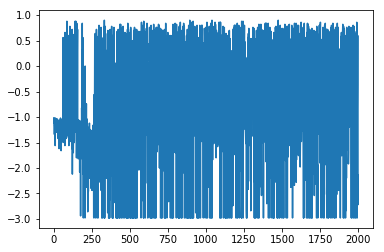

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(reward_list)

In [77]:
env.close()
gym.upload('./monitor', api_key='sk_Iq0FtSUSFyL9rQx6CITg')

[2017-07-15 09:01:37,571] [FrozenLake-v0] Uploading 2000 episodes of training data
[2017-07-15 09:01:41,647] [FrozenLake-v0] Uploading videos of 12 training episodes (1437 bytes)
[2017-07-15 09:01:42,273] [FrozenLake-v0] Creating evaluation object from ./monitor with learning curve and training video
[2017-07-15 09:01:42,807] 
****************************************************
You successfully uploaded your evaluation on FrozenLake-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_LR1qmq6jQa2i3PU82MCd8A

****************************************************
